# SPICY Tutorial 3
This is the second tutorial exercise which deals with the flow around a cylinder. 

We start again by importing the relevant packages and customizing the plots. For this, LaTeX needs to be installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io
from spicy_class_2103 import spicy

# This is for plot customization
fontsize = 16
plt.rc('text', usetex=True)      
plt.rc('font', family='serif')
plt.rcParams['xtick.labelsize'] = fontsize
plt.rcParams['ytick.labelsize'] = fontsize
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['font.size'] = fontsize

This test case is the 2D flow past a cylinder which is a typical benchmark test case. The data is taken from https://github.com/Raocp/PINN-laminar-flow. The geometry has a height of $0.41\,$m, a length of $1.1\,$m and the cylinder a radius of $0.02\,$m. The solution is provided in the form of a Matlab file which is read with scipy.

For the preparation of the dataset, we must first remove the points at the inlet and at the wall, as these are given in the form of constraints. Afterwards, we can extract a defined number of points for our regression (up to 18755). As for the Oseen vortex, we add 10% noise to the velocity data.

In [2]:
# Fix random seed to ensure reproducibility
np.random.seed(42)

# Properties of the domain and flow
R = 0.05 # m
H = 0.41 # m
L = 1.1 # m
mu = 2e-2 # Pa s
rho = 1 # kg/m^3

# Load the matlab data from the ansys solution
data = scipy.io.loadmat('FluentSol.mat')
# Extract the x, y values
X = data['x'].reshape(-1)
Y = data['y'].reshape(-1) 
# Extract the velocities
U = data['vx'].reshape(-1)
V = data['vy'].reshape(-1)
P = data['p'].reshape(-1)

# Here, we remove the points at the inlet and at the wall, as they are given by the constraints
inlet_and_wall_remover = np.invert(np.logical_or(np.logical_and(U==0, V==0), X==0))
# Remove the points
X = X[inlet_and_wall_remover]
Y = Y[inlet_and_wall_remover]
P = P[inlet_and_wall_remover]
U = U[inlet_and_wall_remover]
V = V[inlet_and_wall_remover]

# From the remaining points we can choose to sample a random amount if we want to go for a smaller test case. In this
# tutorial, we take the maximum number of points which is 18755
n_p = 18755
random_points_indices = np.random.randint(low=0, high=len(X), size=n_p)
# Select the data points
X = X[random_points_indices]
Y = Y[random_points_indices]
P = P[random_points_indices]
U = U[random_points_indices]
V = V[random_points_indices]

# Add 10% noise to the velocity field
q = 0.1
U_noise = U * (1 + q * np.random.uniform(-1, 1, size = U.shape))
V_noise = V * (1 + q * np.random.uniform(-1, 1, size = V.shape))

## Velocity regression

We start with the regression of the velocity field.

#### Step 1: Initialize the SPICY class

In [3]:
SP_vel = spicy([U_noise,V_noise], [X,Y], basis='gauss')

#### Step 2: Peform the clustering

The cylinder has some global 'trends': Behind the cylinder, both the pressure and the velocity field do not experience sharp gradients. Therefore, it is useful to have some flat RBFs, which is why we add the third clustering level which gives very flat RBFs.

In [4]:
SP_vel.clustering([6,50,1800], r_mM=[0.015,0.5], eps_l=0.83)

Clustering level 0 completed
Clustering level 1 completed
Clustering level 2 completed


#### Step 3: Define the boundary conditions

For the velocity field, we have Dirichlet and divergence-free conditions. On each of the five boundaries, we sample 150 constraint points, removing duplicates. The Dirichlet conditions are a velocity of $0$ at the top, bottom and cylinder wall as well as a parabolic profile at the inlet. In these points, we also enforce a divergence-free flow. At the outlet, a divergence-free flow is also enforced.

In [5]:
# Number of constraints on each boundary
n_c = 150 

# Left boundary
X_Div1 = np.zeros(n_c)
Y_Div1 = np.linspace(0, H, n_c)
U_Dir1 = 4*(H-Y_Div1)*Y_Div1/H**2
V_Dir1 = np.zeros(X_Div1.shape)
# Bottom boundary
X_Div2 = np.linspace(0, L, n_c)
Y_Div2 = np.zeros(n_c)
U_Dir2 = np.zeros(X_Div2.shape)
V_Dir2 = np.zeros(X_Div2.shape)
# Right boundary
X_Div3 = np.ones(n_c-2)*L
Y_Div3 = np.linspace(0, H, n_c)[1:-1]
# Top boundary
X_Div4 = np.linspace(0, L, n_c)
Y_Div4 = np.ones(n_c)*H
U_Dir4 = np.zeros(X_Div4.shape)
V_Dir4 = np.zeros(X_Div4.shape)
# Cylinder boundary
alphaT = np.linspace(0, 2*np.pi, n_c, endpoint = False)
X_Div5 = 0.2+R*np.cos(alphaT)
Y_Div5 = 0.2+R*np.sin(alphaT)
U_Dir5 = np.zeros(X_Div5.shape)
V_Dir5 = np.zeros(X_Div5.shape)

# We assemble the velocity constraints for Dirichlet
X_Dir = np.concatenate((X_Div1, X_Div2, X_Div4, X_Div5))
Y_Dir = np.concatenate((Y_Div1, Y_Div2, Y_Div4, Y_Div5))
U_Dir = np.concatenate((U_Dir1, U_Dir2, U_Dir4, U_Dir5))
V_Dir = np.concatenate((V_Dir1, V_Dir2, V_Dir4, V_Dir5))
# and Divergence-free flow
X_Div = np.concatenate((X_Div1, X_Div2, X_Div3, X_Div4, X_Div5))
Y_Div = np.concatenate((Y_Div1, Y_Div2, Y_Div3, Y_Div4, Y_Div5))

# We remove the duplicates in the Dirchlet 
_, valid_idcs = np.unique(np.column_stack((X_Div, Y_Div)), return_index = True, axis = 0)
X_Div = X_Div[valid_idcs]
Y_Div = Y_Div[valid_idcs]
DIV = [X_Div, Y_Div]
# and Divergence-free conditions
_, valid_idcs = np.unique(np.column_stack((X_Dir, Y_Dir)), return_index = True, axis = 0)
X_Dir = X_Dir[valid_idcs]
Y_Dir = Y_Dir[valid_idcs]
U_Dir = U_Dir[valid_idcs]
V_Dir = V_Dir[valid_idcs]
DIR = [X_Dir, Y_Dir, U_Dir, V_Dir]

# We set the constraints in these points and also place additional RBFs in each of these points
SP_vel.vector_constraints(DIR=DIR, DIV=DIV, extra_RBF=True)

598 D conditions assigned
0 N conditions assigned
746 Div conditions assigned


We can look at the clustering result, the left-hand side shows the RBFs in 2D, the right hand side shows the diameter distribution.

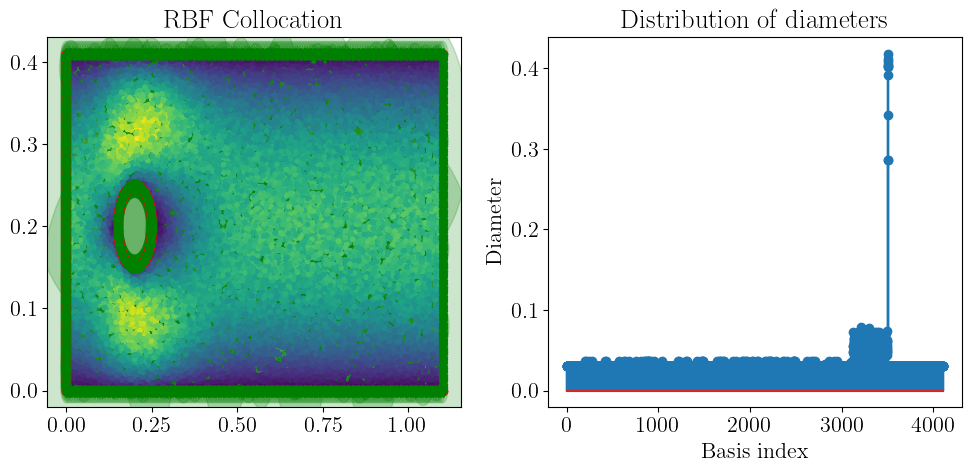

In [6]:
SP_vel.plot_RBFs()

#### Step 4: Assemble the linear system
We assemble the regression, with a penalty for a divergence-free flow.

In [7]:
SP_vel.Assembly_Regression(alpha_div=1)

#### Step 5: Solve the linear system
We solve the system, with a fixed condition number of $10^8$ for the matrix $A$. The matrix $M$ is only regularized in this way if the cholesky factorization fails. This is the case here, so we make use of the regularization for $M$ as well with the same conditioning number.

In [8]:
SP_vel.Solve(K_cond=1e12)

Solving with constriaints
Matrix A regularized
Chol factor of M WITH regularization
Lambdas computed
w computed


#### Step 6: Obtain the solution
Here, we use the same grid points as before for an easier comparison, However, this grid can be completely arbitrary!

In [9]:
solution_velocity = SP_vel.Get_Sol(grid=[X,Y])
# Extract individual velocity components
U_calc = solution_velocity[:n_p]
V_calc = solution_velocity[n_p:]

We can now compute the error in the magnitude.

In [10]:
# Magnitude of the RBF solution
U_magn_calc = np.sqrt(U_calc**2 + V_calc**2)
# Compute the magnitude of the analytical solution
U_magn = np.sqrt(U**2 + V**2)
# Compute the error in the magnitude
error_magn = np.linalg.norm(U_magn_calc - U_magn) / np.linalg.norm(U_magn)
# Error in u
error_u = np.linalg.norm(U_calc - U) / np.linalg.norm(U)
# Error in v
error_v = np.linalg.norm(V_calc - V) / np.linalg.norm(V)

print('Total velocity error: {0:.3f}%'.format(error_magn*100))
print('Velocity error in u:  {0:.3f}%'.format(error_u*100))
print('Velocity error in v:  {0:.3f}%'.format(error_v*100))

Total velocity error: 0.851%
Velocity error in u:  0.852%
Velocity error in v:  3.475%


We achieve a very good error below 2% on the global velocity magnitude. This is mostly dominated by the flow in $x$-direction as this is the main flow component with the highest magnitude. This is also evidenced by the plots below.

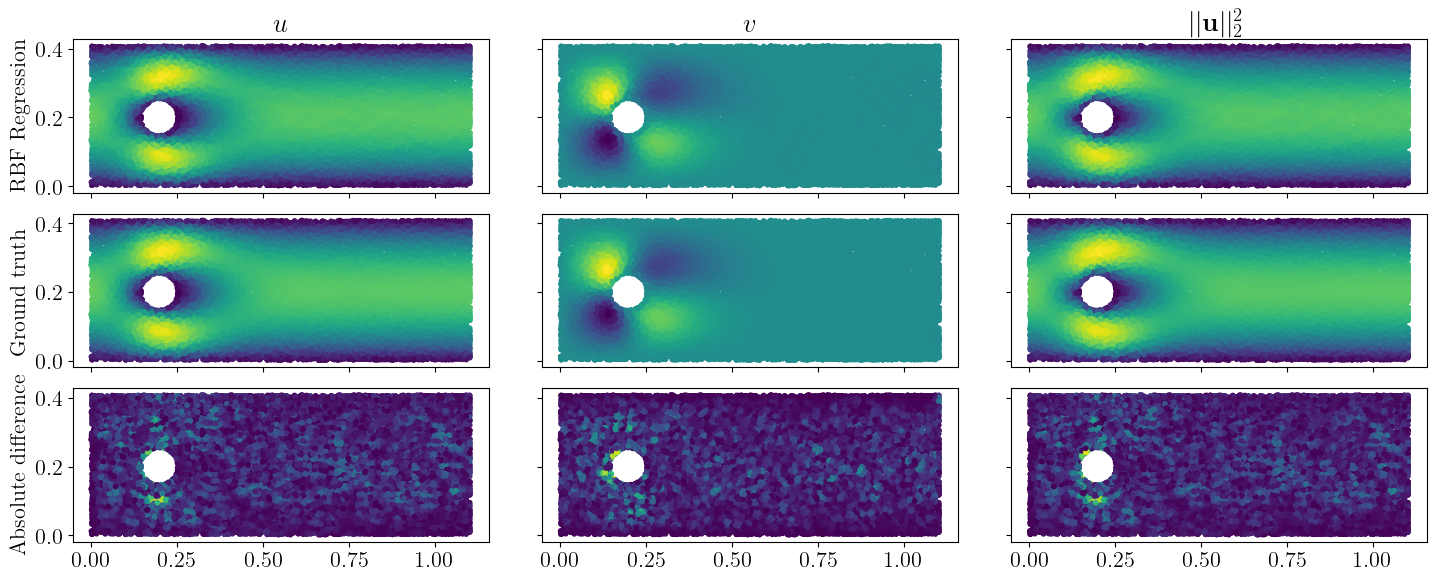

In [29]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(15,6), dpi=100, sharex=True, sharey=True)
axes[0,0].scatter(X, Y, c=U_calc, s=10)
axes[1,0].scatter(X, Y, c=U, s=10)
axes[2,0].scatter(X, Y, c=np.abs(U_calc-U), s=10) 

axes[0,1].scatter(X, Y, c=V_calc, s=10)
axes[1,1].scatter(X, Y, c=V, s=10)
axes[2,1].scatter(X, Y, c=np.abs(V_calc-V), s=10)  

axes[0,2].scatter(X, Y, c=U_magn_calc, s=10)
axes[1,2].scatter(X, Y, c=U_magn, s=10)
axes[2,2].scatter(X, Y, c=np.abs(U_magn_calc-U_magn), s=10) 


axes[0,0].set_ylabel('RBF Regression') 
axes[1,0].set_ylabel('Ground truth')  
axes[2,0].set_ylabel('Absolute difference')  

axes[0,0].set_title('$u$') 
axes[0,1].set_title('$v$')  
axes[0,2].set_title('$||\mathbf{u}||_2^2$')      
for ax in axes.flatten():
    ax.set_aspect(1)      
fig.tight_layout()      

From left to right, the figure shows the velocity component $u$, $v$ as well as the magnitude. From top to bottom the rows show the computed velocity, the ground truth and the absolute difference. The error is uniformly distributed and strongest around the cylinder where the largest gradients are present which is expected. With the analytic expression of the velocity field, we can now continue with the pressure integration



## Pressure integration

For the pressure, we must compute two quantities from the velocity field. The first is the r.h.s. of equation (21) which is available analytically. The second are the values of the Neumann conditions on the boundaries, from equation (29).

We evaluate the source term on the original grid points, but this can also be an arbitrary grid.

In [12]:
# Get the source term
source_term = SP_vel.Evaluate_Source_Term(grid=[X,Y], rho=rho)

For the boundary conditions, we must again define the points in which we want to compute them. In the simulations, there is a constant pressure of $0$ at the outlet, which we enforce with 148 Dirichlet boundary conditions at the outlet. On the other boundaries, we compute the normal derivative of the pressure based on the velocity field.

In [13]:
# Number of constraints on each boundary
n_c = 150 

# We start with the Neumann conditions
# Left boundary
X_Pres_N1 = np.zeros(n_c)
Y_Pres_N1 = np.linspace(0, H, n_c)
# Bottom boundary
X_Pres_N2 = np.linspace(0.0,L,n_c)
Y_Pres_N2 = np.zeros(n_c)
# Top boundary
X_Pres_N4 = np.linspace(0, L, n_c)
Y_Pres_N4 = np.ones(n_c)*H
# Cylinder boundary
alpha_P = np.linspace(0, 2*np.pi, n_c, endpoint = False) 
X_Pres_N5 = 0.2 + R*np.cos(alpha_P)
Y_Pres_N5 = 0.2 + R*np.sin(alpha_P)
# Assemble the the entire array of Neumann points
X_Pres_N=np.hstack((X_Pres_N1, X_Pres_N2, X_Pres_N4, X_Pres_N5))
Y_Pres_N=np.hstack((Y_Pres_N1, Y_Pres_N2, Y_Pres_N4, Y_Pres_N5))

# We assemble the normals in the same way
# Left boundary
n_x_1 = np.ones(X_Pres_N1.shape)*(-1)
n_y_1 = np.ones(X_Pres_N1.shape)*0
# Bottom boundary
n_x_2 = np.ones(X_Pres_N2.shape)*0
n_y_2 = np.ones(X_Pres_N2.shape)*(-1)
# Top boundary
n_x_4 = np.ones(X_Pres_N4.shape)*0
n_y_4 = np.ones(X_Pres_N4.shape)*1
# Cylinder boundary
n_x_5 = np.ones(X_Pres_N5.shape)*(-np.cos(alpha_P))
n_y_5 = np.ones(X_Pres_N5.shape)*(-np.sin(alpha_P))
# Assemble to obtain the entire array of Neumann normals
n_x = np.hstack((n_x_1, n_x_2, n_x_4, n_x_5))
n_y = np.hstack((n_y_1, n_y_2, n_y_4, n_y_5))  

# Remove the duplicates for the normals
_, valid_idcs = np.unique(np.column_stack((X_Pres_N, Y_Pres_N)),
                          return_index = True, axis = 0)
X_Pres_N = X_Pres_N[valid_idcs]
Y_Pres_N = Y_Pres_N[valid_idcs]
n_x = n_x[valid_idcs]
n_y = n_y[valid_idcs]

# The last thing are the Dirichlet conditions at the outlet
# Right boundary
X_Pres_D3 = np.ones(n_c-2)*L
Y_Pres_D3 = np.linspace(0, H, n_c)[1:-1]

# Evaluate the Neumann conditions in these points
P_Neu = SP_vel.Get_Pressure_Neumann(grid = [X_Pres_N, Y_Pres_N], normals = [n_x, n_y],
                                    rho = rho, mu = mu)

# The Dirichlet conditions do not have any overlap with the Neumann conditions, so we can just take them as they are
X_Pres_D = X_Pres_D3
Y_Pres_D = Y_Pres_D3
P_Pres_D = np.zeros(X_Pres_D.shape)

Now, we have all of the quantities, that we need from the velocity. The velocity spicy class can now be deleted, to save memory but for the sake of this tutorial, all variables are kept.

#### Step 1: Initialize the SPICY class

In [14]:
SP_pres = spicy([source_term], [X,Y], basis='gauss')

#### Step 2: Peform the clustering

In [15]:
SP_pres.clustering([6,50,1800], r_mM=[0.015, 0.5], eps_l=0.83)

Clustering level 0 completed
Clustering level 1 completed
Clustering level 2 completed


#### Step 3: Define the boundary conditions
We use 195 Neumann and one Dirichlet boundary condition.

In [16]:
# We assemble our Neumann and Dirichlet B.C.
NEU_P = [X_Pres_N, Y_Pres_N, n_x, n_y, P_Neu]
DIR_P = [X_Pres_D, Y_Pres_D, P_Pres_D]

# And, we set them
SP_pres.scalar_constraints(DIR=DIR_P, NEU=NEU_P, extra_RBF=True)

148 Dirichlet conditions assigned
598 Neumann conditions assigned


#### Step 4: Assemble the linear system
We assemble the regression, with no harmonic basis.

In [17]:
SP_pres.Assembly_Poisson(n_hb = 0)

#### Step 5: Solve the linear system
We solve the system, witha fixed condition number of $10^{12}$.

In [18]:
SP_pres.Solve(K_cond=1e12)

Solving with constriaints
Matrix A regularized
Chol factor of M WITH regularization
Lambdas computed
w computed


#### Step 6 Obtain the solution

In [19]:
P_calc = SP_pres.Get_Sol(grid=[X,Y])

We can now compute the error in the magnitude

In [20]:
# print the pressure error
error_p = np.linalg.norm(P_calc-P)/np.linalg.norm(P)
print('Total pressure error: {0:.3f}%'.format(error_p*100))

Total pressure error: 3.872%


We close by comparing the calculated and ground truth pressure field.

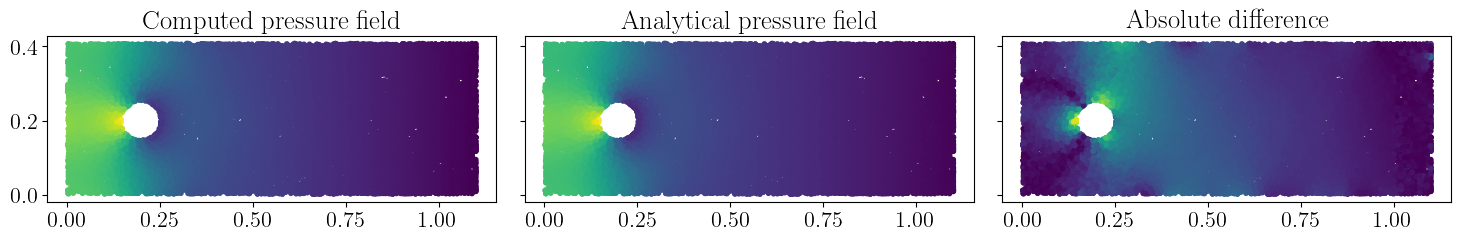

In [22]:
fig, axes = plt.subplots(figsize=(15,3), dpi=100, ncols=3, sharey=True)
axes[0].scatter(X, Y, c=P_calc, s=10)
axes[0].set_title('Computed pressure field')
axes[1].scatter(X, Y, c=P, s=10)
axes[1].set_title('Analytical pressure field')
axes[2].scatter(X, Y, c=np.abs(P_calc-P), s=10)
axes[2].set_title('Absolute difference')           
for ax in axes.flatten():
    ax.set_aspect(1)
fig.tight_layout()

As expected, the difference in the pressure field is the strongest in the center, where the largest gradient is located. However, the error is neglibile given the fact that there is 10% noise on the velocity data.